In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
n_mfcc = 40
n_fft = 1024  # setting the FFT size to 1024
hop_length = 10*16 # 25ms*16khz samples has been taken
win_length = 25*16 #25ms*16khz samples has been taken for window length
window = 'hann' #hann window used
n_chroma=12
n_mels=128
n_bands=7 #we are extracting the 7 features out of the spectral contrast
fmin=100
bins_per_ocatve=12

#mel spectrogram =128
#chromagram=12
#spectral contrast =7
#tonetz=6

In [ ]:

# Define function to extract features
def extract_features(file_path):
    try:
        # Load audio file and extract features
        y, sr = librosa.load(file_path, sr=16000)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann', n_mels=n_mels).T, axis=0)
        stft = np.abs(librosa.stft(y))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_bands=n_bands, fmin=fmin).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)
        features = {
            'mfcc': mfcc,
            'chroma': chroma,
            'mel': mel,
            'contrast': contrast,
            'tonnetz': tonnetz
        }
        return features
    except Exception as e:
        print(f"Error: Exception occurred in feature extraction: {e}")
        return None
import zipfile
import os
# Define path to the zip file
zip_file_path = '/content/drive/MyDrive/donateacry_corpus_dataset.zip'

# Extract the contents of the zip file to a temporary directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')

# Define path to the extracted directory
extracted_path = '/content/extracted_data/donateacry_corpus_dataset'

# Initialize empty lists to hold extracted features and labels
features = []
labels = []
file_paths = []

# Loop through the directories in the extracted directory
for label in os.listdir(extracted_path):
    label_path = os.path.join(extracted_path, label)
    if os.path.isdir(label_path):  # Check if it's a directory
        # Loop through the files in each directory
        print(f"{label} data is loading.....")
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            # Extract features and append to list
            feature_dict = extract_features(file_path)
            if feature_dict is not None:
                features.append(feature_dict)
                labels.append(label)
                file_paths.append(file_path)
        print(f"{label} data loaded....")

hungry data is loading.....
hungry data loaded....
discomfort data is loading.....
discomfort data loaded....
belly_pain data is loading.....
belly_pain data loaded....
burping data is loading.....
burping data loaded....
tired data is loading.....
tired data loaded....


In [ ]:
df = pd.DataFrame(features)
df['label'] = labels
df['file_path'] = file_paths

# Save DataFrame to CSV if needed
df.to_csv('extracted_features.csv', index=False)

print("Feature extraction and labeling completed.")
df.shape
print(df.sample(2))

Feature extraction and labeling completed.
                                                 mfcc  \
85  [-523.9075, 69.71267, -55.304756, 16.057222, -...   
21  [-397.77866, 112.591034, -40.71443, 8.406364, ...   

                                               chroma  \
85  [0.5405288, 0.644741, 0.7474856, 0.76395106, 0...   
21  [0.429933, 0.38559788, 0.35291645, 0.31601098,...   

                                                  mel  \
85  [1.1623984e-05, 4.8681235e-05, 0.00011247216, ...   
21  [0.004175329, 0.0020566497, 0.0007578448, 0.00...   

                                             contrast  \
85  [23.596055333864193, 10.291727155932548, 12.35...   
21  [10.656401543746785, 11.925399700581487, 17.13...   

                                              tonnetz   label  \
85  [0.007485319958209276, 0.008488284116665697, -...  hungry   
21  [-0.0043409860566685395, -0.06191789163925472,...  hungry   

                                            file_path  
85  /content/extr

In [ ]:
!pip install imbalanced-learn

In [ ]:
def expand_features(df, feature_name):
    feature_df = pd.DataFrame(df[feature_name].tolist(), index=df.index)
    feature_df.columns = [f"{feature_name}_{i}" for i in range(feature_df.shape[1])]
    return feature_df

mfcc_df = expand_features(df, 'mfcc')
chroma_df = expand_features(df, 'chroma')
mel_df = expand_features(df, 'mel')
contrast_df = expand_features(df, 'contrast')
tonnetz_df = expand_features(df, 'tonnetz')

expanded_df = pd.concat([mfcc_df, chroma_df, mel_df, contrast_df, tonnetz_df], axis=1)
expanded_df['label'] = df['label']
expanded_df['file_path'] = df['file_path']

X = expanded_df.drop(columns=['label', 'file_path'])
y = expanded_df['label']

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X = expanded_df.drop(columns=['label', 'file_path'])
y = expanded_df['label']
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['label'] = y_resampled
csv_file_path = 'balanced_extracted_features.csv'
df_resampled.to_csv(csv_file_path, index=False)
df_resampled.head()

<ipython-input-8-6f762be29e69>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['label'] = y_resampled


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,contrast_5,contrast_6,contrast_7,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,label
0,-342.756378,202.213028,-1.444421,34.129719,6.115108,-6.558093,14.946250,-13.441131,-1.890066,2.217819,...,17.310166,58.776136,10.101565,0.003252,0.006902,0.006588,0.002858,0.002339,0.005460,hungry
1,-442.617279,83.562698,-76.688866,-7.274812,0.685521,-11.187461,0.323565,-11.639539,4.917588,-2.735130,...,21.504522,69.039694,22.559672,0.029450,0.022864,0.047494,-0.036167,0.015406,-0.006466,hungry
2,-477.261841,107.122803,-26.311687,14.027479,1.272555,-10.661127,5.985491,-12.023480,-2.371422,4.807252,...,17.862097,60.263757,14.124568,-0.020290,0.017719,-0.027481,0.043351,-0.011813,0.003547,hungry
3,-456.945129,101.555252,-65.977249,-2.142158,-25.829647,-31.609804,2.285047,-17.567739,-8.276935,-6.931462,...,18.484737,66.925388,17.609880,-0.003709,0.000207,0.014546,-0.035777,-0.000594,-0.009004,hungry
4,-428.822357,158.566757,-69.108986,27.945744,-4.210147,-14.831765,20.201841,-19.480927,-3.625303,-11.074046,...,16.263510,71.556687,18.756201,-0.057659,-0.019681,0.006219,0.012900,-0.025463,-0.011459,hungry


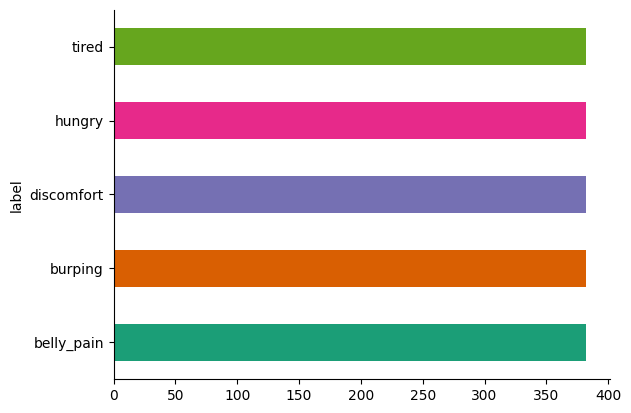

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_resampled.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Accuracy of KNeighborsClassifier: 97.90575916230367
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.98      1.00      0.99        79
     burping       1.00      1.00      1.00        75
  discomfort       0.94      1.00      0.97        77
      hungry       1.00      0.90      0.95        78
       tired       0.99      1.00      0.99        73

    accuracy                           0.98       382
   macro avg       0.98      0.98      0.98       382
weighted avg       0.98      0.98      0.98       382



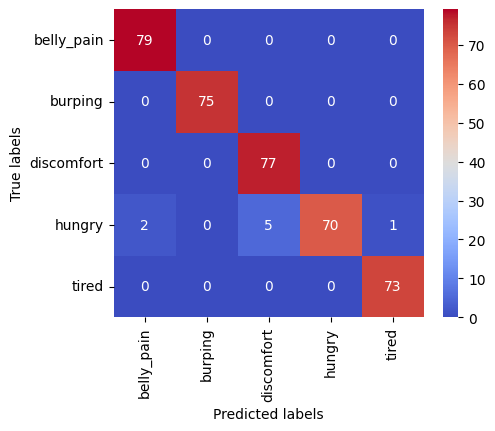

In [ ]:
#KNN
from sklearn.metrics import classification_report,confusion_matrix
knc = KNeighborsClassifier(n_neighbors=1)
knc.fit(X_train,y_train)
y_pred = knc.predict(X_test)
print(f"Accuracy of KNeighborsClassifier: {accuracy_score(y_test,y_pred)*100}")
classification_report = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report)
conf_matrix_1 = confusion_matrix(y_test, y_pred)
label_names = ['belly_pain','burping','discomfort','hungry','tired']
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy of RandomForestClassifier: 99.73821989528795
Classification Report:
               precision    recall  f1-score   support

  belly_pain       1.00      1.00      1.00        79
     burping       0.99      1.00      0.99        75
  discomfort       1.00      1.00      1.00        77
      hungry       1.00      0.99      0.99        78
       tired       1.00      1.00      1.00        73

    accuracy                           1.00       382
   macro avg       1.00      1.00      1.00       382
weighted avg       1.00      1.00      1.00       382



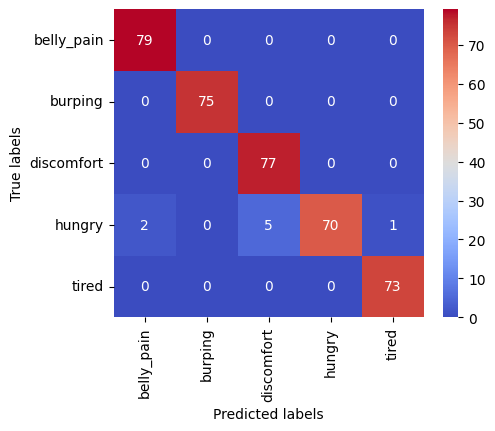

In [ ]:
#RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
rfc = RandomForestClassifier(n_estimators=120, random_state = 110)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(f"Accuracy of RandomForestClassifier: {accuracy_score(y_test,y_pred)*100}")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain','burping','discomfort','hungry','tired']
conf_matrix_2 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy of Linear SVC: 93.717277486911
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.96      1.00      0.98        79
     burping       0.94      1.00      0.97        75
  discomfort       0.87      1.00      0.93        77
      hungry       1.00      0.69      0.82        78
       tired       0.95      1.00      0.97        73

    accuracy                           0.94       382
   macro avg       0.94      0.94      0.93       382
weighted avg       0.94      0.94      0.93       382



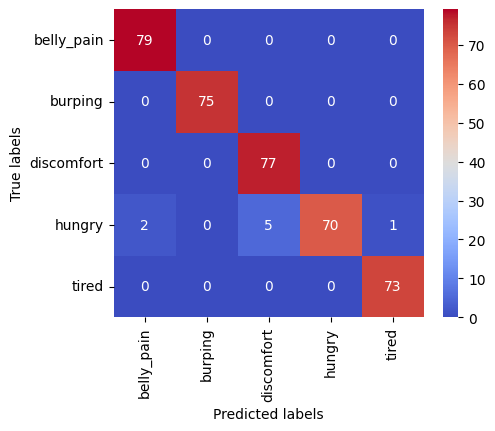

In [ ]:
#SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
svc_model = SVC(kernel = 'linear', random_state=15)
svc_model.fit(X_train,y_train)
y_pred = svc_model.predict(X_test)
print(f"Accuracy of Linear SVC: {accuracy_score(y_test,y_pred)*100}")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain','burping','discomfort','hungry','tired']
conf_matrix_3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy of PCA: 91.62303664921467
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.85      1.00      0.92        79
     burping       0.99      1.00      0.99        75
  discomfort       0.84      0.99      0.90        77
      hungry       0.98      0.60      0.75        78
       tired       0.99      1.00      0.99        73

    accuracy                           0.92       382
   macro avg       0.93      0.92      0.91       382
weighted avg       0.93      0.92      0.91       382



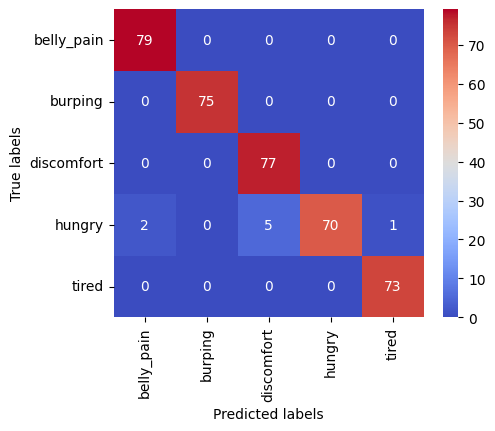

In [ ]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=45)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
svm_classifier = SVC(kernel='linear', C=3.7)
svm_classifier.fit(X_train_pca, y_train)
y_pred = svm_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of PCA: {accuracy*100}")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain','burping','discomfort','hungry','tired']
conf_matrix_4 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy of DecisionTree: 96.8586387434555
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.99      1.00      0.99        79
     burping       0.96      1.00      0.98        75
  discomfort       0.96      1.00      0.98        77
      hungry       1.00      0.85      0.92        78
       tired       0.94      1.00      0.97        73

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



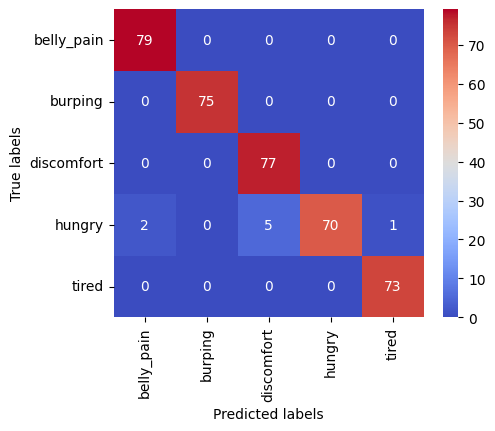

In [ ]:
#DT
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=40)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of DecisionTree: {accuracy*100}")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain','burping','discomfort','hungry','tired']
conf_matrix_5 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found: {'learning_rate': 1.5, 'n_estimators': 150}
Accuracy of AdaBoostClassifier: 61.25654450261781
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.79      0.68      0.73        79
     burping       1.00      1.00      1.00        75
  discomfort       0.61      0.35      0.45        77
      hungry       0.38      0.88      0.53        78
       tired       0.75      0.12      0.21        73

    accuracy                           0.61       382
   macro avg       0.71      0.61      0.58       382
weighted avg       0.70      0.61      0.59       382



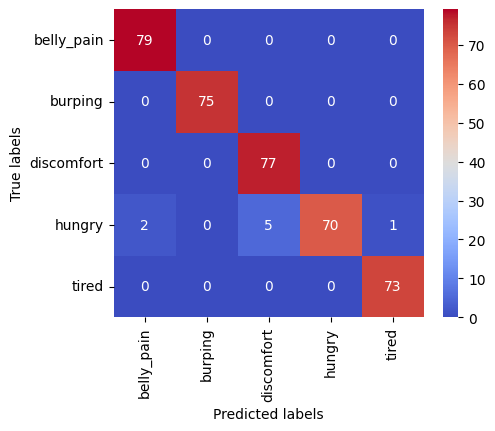

In [ ]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 50, 100,150],
    'learning_rate': [0.01, 0.1, 0.5, 1, 1.5]
}

abc = AdaBoostClassifier()
grid_search = GridSearchCV(estimator=abc, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(f"Best parameters found: {best_params}")

# Predict with the best estimator
y_pred = best_estimator.predict(X_test)
print(f"Accuracy of AdaBoostClassifier: {accuracy_score(y_test,y_pred)*100}")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain','burping','discomfort','hungry','tired']
conf_matrix_6 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cross_val_scores = cross_val_score(extra_trees, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation accuracy: {cross_val_scores.mean() * 100:.2f}%")

NameError: name 'extra_trees' is not defined

In [ ]:
print(f"Overlap between training and testing sets: {set(X_train.index).intersection(set(X_test.index))}")


Overlap between training and testing sets: set()


In [ ]:
duplicate_rows = expanded_df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

Number of duplicate rows: 0


In [ ]:
print(expanded_df.info())

# Check for any potential non-numeric columns that should be excluded
print(expanded_df.select_dtypes(include=['object']).head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Columns: 196 entries, mfcc_0 to file_path
dtypes: float32(180), float64(14), object(2)
memory usage: 378.6+ KB
None
    label                                          file_path
0  hungry  /content/extracted_data/donateacry_corpus_data...
1  hungry  /content/extracted_data/donateacry_corpus_data...
2  hungry  /content/extracted_data/donateacry_corpus_data...
3  hungry  /content/extracted_data/donateacry_corpus_data...
4  hungry  /content/extracted_data/donateacry_corpus_data...


In [ ]:
numeric_df = expanded_df.drop(columns=['label', 'file_path'], errors='ignore')
print(numeric_df.dtypes)
correlation_matrix = numeric_df.corr()
# Plot heatmap of the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
print(expanded_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Columns: 196 entries, mfcc_0 to file_path
dtypes: float32(180), float64(14), object(2)
memory usage: 378.6+ KB
None


Accuracy of ExtraTreesClassifier: 100.00%
Classification Report:
               precision    recall  f1-score   support

  belly_pain       1.00      1.00      1.00        79
     burping       1.00      1.00      1.00        75
  discomfort       1.00      1.00      1.00        77
      hungry       1.00      1.00      1.00        78
       tired       1.00      1.00      1.00        73

    accuracy                           1.00       382
   macro avg       1.00      1.00      1.00       382
weighted avg       1.00      1.00      1.00       382



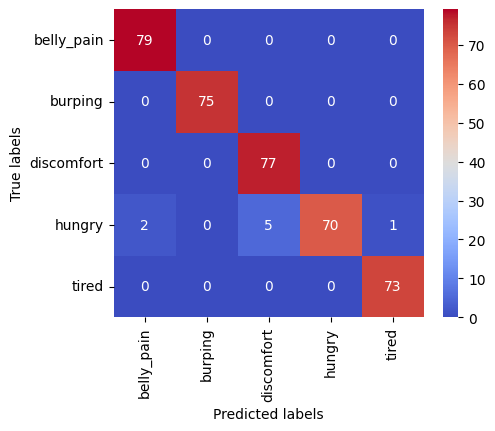

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report,confusion_matrix
extra_trees = ExtraTreesClassifier(random_state=30)
extra_trees.fit(X_train, y_train)
y_pred = extra_trees.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of ExtraTreesClassifier: {accuracy * 100:.2f}%")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain','burping','discomfort','hungry','tired']
conf_matrix_7 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy of GMMClassifier: 100.00%
Classification Report:
               precision    recall  f1-score   support

  belly_pain       1.00      1.00      1.00        79
     burping       1.00      1.00      1.00        75
  discomfort       1.00      1.00      1.00        77
      hungry       1.00      1.00      1.00        78
       tired       1.00      1.00      1.00        73

    accuracy                           1.00       382
   macro avg       1.00      1.00      1.00       382
weighted avg       1.00      1.00      1.00       382



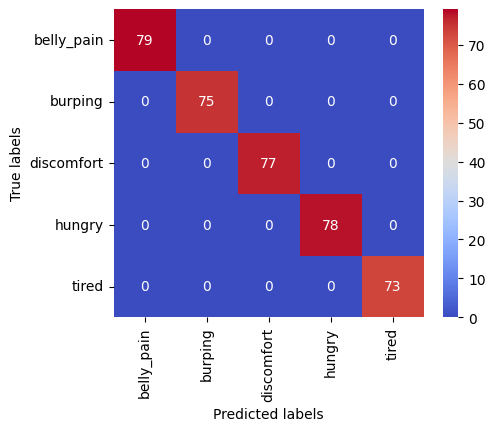

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

class GMMClassifier:
    def __init__(self, n_components=5, random_state=30):
        self.n_components = n_components
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for label in self.classes_:
            gmm = GaussianMixture(n_components=self.n_components, random_state=self.random_state)
            gmm.fit(X[y == label])
            self.models.append(gmm)

    def predict(self, X):
        likelihoods = np.array([model.score_samples(X) for model in self.models]).T
        return self.classes_[np.argmax(likelihoods, axis=1)]

gmm_classifier = GMMClassifier()
gmm_classifier.fit(X_train, y_train)
y_pred = gmm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of GMMClassifier: {accuracy * 100:.2f}%")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
conf_matrix_8 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_8, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


Accuracy of Stoichastic Gradient Descent: 95.02617801047121
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.94      1.00      0.97        79
     burping       1.00      1.00      1.00        75
  discomfort       0.90      1.00      0.94        77
      hungry       1.00      0.76      0.86        78
       tired       0.94      1.00      0.97        73

    accuracy                           0.95       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382



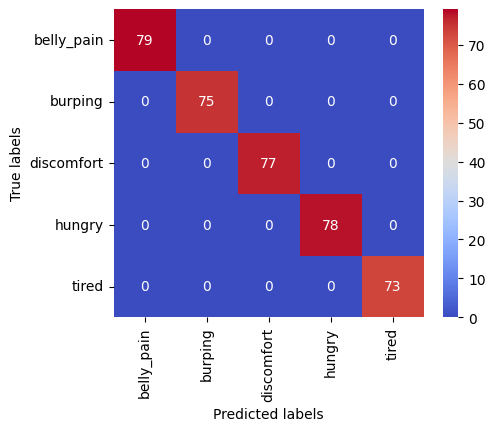

In [ ]:
#SGD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sgd_classifier = SGDClassifier(loss='log_loss', max_iter=1000, random_state=55)
sgd_classifier.fit(X_train_scaled, y_train)
y_pred = sgd_classifier.predict(X_test_scaled)
print(f"Accuracy of Stoichastic Gradient Descent: {accuracy_score(y_test, y_pred)*100}")
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
conf_matrix_9 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_8, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy of XGBoostClassifier: 99.74%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        77
           3       1.00      0.99      0.99        78
           4       0.99      1.00      0.99        73

    accuracy                           1.00       382
   macro avg       1.00      1.00      1.00       382
weighted avg       1.00      1.00      1.00       382



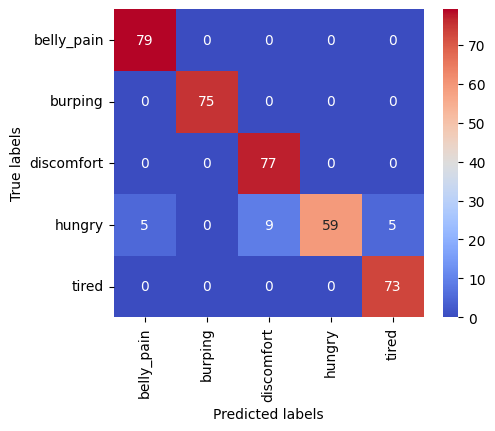

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
xgb_classifier = XGBClassifier(random_state=30, use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train_encoded)
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy of XGBoostClassifier: {accuracy * 100:.2f}%")
report = classification_report(y_test_encoded, y_pred)
print("Classification Report:\n", report)
label_names = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
conf_matrix_10 = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_9, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49455
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 194
[LightGBM] [Info] Start training from score -1.617982
[LightGBM] [Info] Start training from score -1.604867
[LightGBM] [Info] Start training from score -1.611403
[LightGBM] [Info] Start training from score -1.614687
[LightGBM] [Info] Start training from score -1.598374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

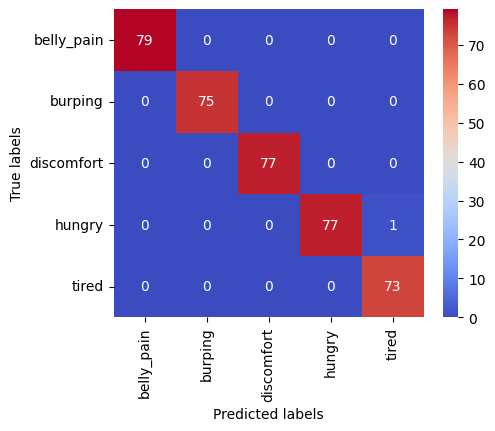

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
lgb_classifier = lgb.LGBMClassifier(random_state=30)
lgb_classifier.fit(X_train, y_train)
y_pred_lgb = lgb_classifier.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"Accuracy of LightGBM Classifier: {accuracy_lgb * 100:.2f}%")

report_lgb = classification_report(y_test, y_pred_lgb)
print("Classification Report for LightGBM Classifier:\n", report_lgb)
label_names = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
conf_matrix_11 = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_10, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 96.60%
Classification Report for MLP Classifier:
               precision    recall  f1-score   support

  belly_pain       0.95      1.00      0.98        79
     burping       1.00      1.00      1.00        75
  discomfort       0.95      1.00      0.97        77
      hungry       1.00      0.83      0.91        78
       tired       0.94      1.00      0.97        73

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.96       382



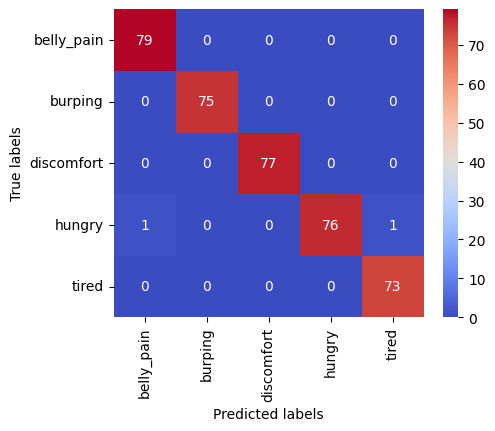

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(random_state=30)
mlp_classifier.fit(X_train, y_train)
y_pred_mlp = mlp_classifier.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy of MLP Classifier: {accuracy_mlp * 100:.2f}%")

report_mlp = classification_report(y_test, y_pred_mlp)
print("Classification Report for MLP Classifier:\n", report_mlp)

conf_matrix_12 = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_11, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

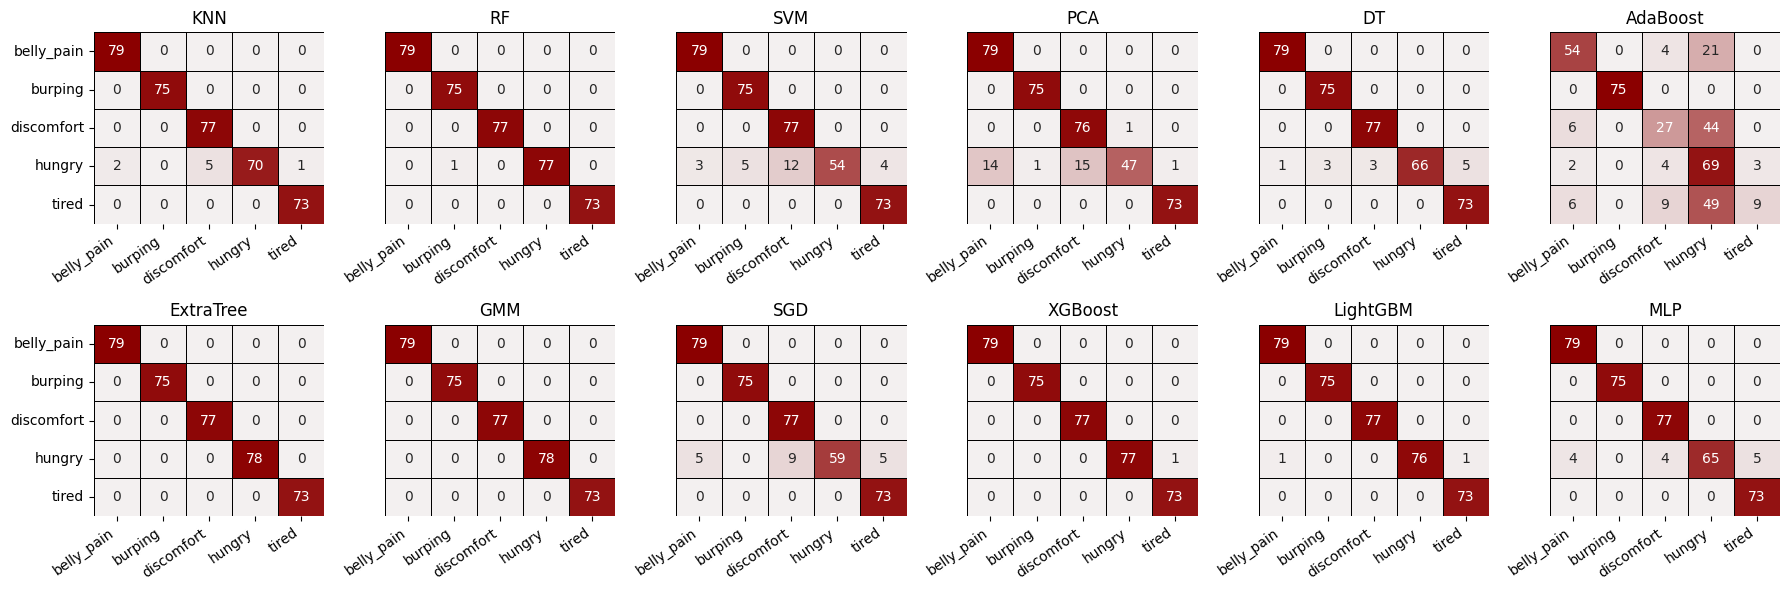

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

# List of classifiers and their respective confusion matrices
classifiers = ["KNN", "RF", "SVM", "PCA", "DT", "AdaBoost", "ExtraTree","GMM","SGD","XGBoost","LightGBM","MLP",]
confusion_matrices = [conf_matrix_1, conf_matrix_2, conf_matrix_3, conf_matrix_4, conf_matrix_5, conf_matrix_6, conf_matrix_7,conf_matrix_8,conf_matrix_9, conf_matrix_10, conf_matrix_11,conf_matrix_12]

cmap = sns.light_palette("darkred", as_cmap=True)

for i, ax in enumerate(axes.flatten()):
    # Plot y labels only for the first matrix in each row
    if i == 0 or i==6:
        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names,cmap=cmap, linewidths=.6, linecolor='black', ax=ax,cbar=False)
    else:
        sns.heatmap(confusion_matrices[i], annot=True, fmt='d',cmap=cmap, linewidths=.6, linecolor='black', xticklabels=label_names ,yticklabels=False, ax=ax,cbar=False)

    ax.set_title(classifiers[i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')


# Adjust layout
plt.tight_layout()
plt.show()